<a href="https://colab.research.google.com/github/anuj0456/deep_learning_for_coders/blob/master/fastai/fastai_lesson3_head_pose.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install fastai==2.2.5
!pip install nbdev

In [2]:
%matplotlib inline

In [3]:
from fastai.vision.all import *
from nbdev.showdoc import *

In [4]:
path = untar_data(URLs.BIWI_HEAD_POSE)

In [5]:
cal = np.genfromtxt(path/'01'/'rgb.cal',skip_footer=6); cal

array([[517.679,   0.   , 320.   ],
       [  0.   , 517.679, 240.5  ],
       [  0.   ,   0.   ,   1.   ]])

In [6]:
fname = '09/frame_00667_rgb.jpg'

In [7]:
def img2txt_name(f): return path/f'{str(f)[:-7]}pose.txt'

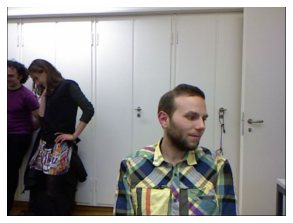

In [8]:
img = PILImage.create(path/fname)
img.show();

In [9]:
ctr = np.genfromtxt(img2txt_name(fname), skip_header=3); ctr #ctr means center

array([187.332 ,  40.3892, 893.135 ])

In [10]:
def convert_biwi(coords):
    c1 = coords[0] * cal[0][0]/coords[2] + cal[0][2]
    c2 = coords[1] * cal[1][1]/coords[2] + cal[1][2]
    return tensor([c1,c2])

def get_ctr(f):
    ctr = np.genfromtxt(img2txt_name(f), skip_header=3)
    return convert_biwi(ctr)

def get_ip(img,pts): return TensorPoint.create(pts, img_size=img.size)

In [11]:
get_ctr(fname)

tensor([428.5814, 263.9104])

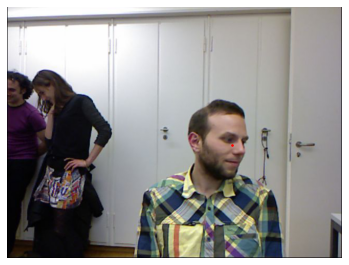

In [12]:
ctr = get_ctr(fname) 
ax = img.show(figsize=(6, 6))
get_ip(img, ctr).show(ctx=ax);

In [13]:
dblock = DataBlock(blocks=(ImageBlock, PointBlock),
                   get_items=get_image_files,
                   splitter=FuncSplitter(lambda o: o.parent.name=='13'),
                   get_y=get_ctr,
                   batch_tfms=[*aug_transforms(size=(120,160)), Normalize.from_stats(*imagenet_stats)])

In [14]:
dls = dblock.dataloaders(path, path=path, bs=64)

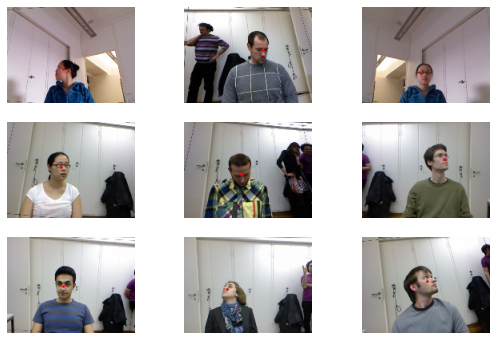

In [15]:
dls.show_batch(max_n=9, figsize=(9,6))

In [16]:
#TODO: look in after_item for c
dls.c = dls.train.after_item.c

In [17]:
learn = cnn_learner(dls, resnet34)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth


SuggestedLRs(lr_min=0.006918309628963471, lr_steep=0.033113110810518265)

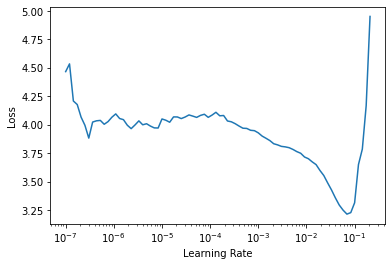

In [18]:
learn.lr_find()

In [19]:
lr = 2e-2

In [20]:
learn.fit_one_cycle(5, slice(lr))

epoch,train_loss,valid_loss,time
0,0.146461,0.106232,01:57
1,0.040094,0.014813,01:57
2,0.015134,0.010292,01:58
3,0.009024,0.001178,01:58
4,0.006902,0.001197,01:58


In [21]:
learn.save('stage-1')

Path('/root/.fastai/data/biwi_head_pose/models/stage-1.pth')

In [22]:
learn.load('stage-1');

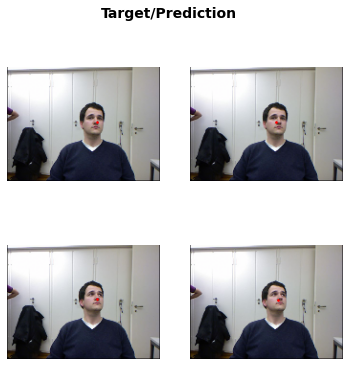

In [23]:
learn.show_results(max_n=6)

In [24]:
def repeat_one_file(path): 
    items = get_image_files(path)
    return [items[0]] * 500

In [25]:
dblock = DataBlock(blocks=(ImageBlock, PointBlock),
                   get_items=repeat_one_file,
                   splitter=RandomSplitter(),
                   get_y=get_ctr)

In [26]:
tfms = aug_transforms(max_rotate=20, max_zoom=1.5, max_lighting=0.5, max_warp=0.4, p_affine=1., p_lighting=1., size=(120,160))

In [27]:
dls = dblock.dataloaders(path, path=path, bs=64, batch_tfms=[*tfms, Normalize.from_stats(*imagenet_stats)])

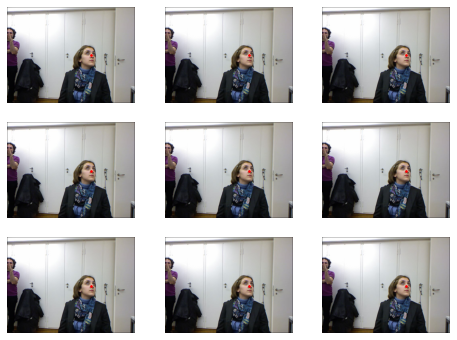

In [28]:
dls.show_batch(max_n=9, figsize=(8,6))